In [ ]:
 pip install tf_keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import keras
print(keras.__version__)

2024-06-09 07:25:11.377263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 07:25:11.377400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 07:25:11.544479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Layer,Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization
from tensorflow.keras.activations import linear, relu, sigmoid
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import save_model
from tensorflow import keras
from tensorflow.keras import layers,models,Model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_hub as hub
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.layers import BatchNormalization

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import random
from os import listdir
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras.utils as image
from sklearn.preprocessing import LabelEncoder

In [ ]:
path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES'
category = os.listdir(path)


data = {"imgpath": [] , "labels": [] }
for cat in category:
    folder = os.path.join(path, cat)
    img_list = os.listdir(folder)
    for img in img_list:
        imgpath = os.path.join(folder, img)
        data['imgpath'].append(imgpath)
        data['labels'].append(cat)
df = pd.DataFrame(data)

# Preprocessing

In [ ]:
df['labels_clean'] = df['labels'].str.extract(r'\d+\. ([^\d\-]+)')

#encoder = LabelEncoder()
#df['encoded_labels'] = encoder.fit_transform(df['labels_clean'])
df['labels_clean'] = df['labels_clean'].str.strip()
print(df.shape)
df.head()

(27153, 3)


,imgpath,labels,labels_clean
0,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema
1,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema
2,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema
3,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema
4,/kaggle/input/skin-diseases-image-dataset/IMG_...,1. Eczema 1677,Eczema


In [ ]:
df['labels_clean'] = df['labels_clean'].replace({
    'Basal Cell Carcinoma (BCC)': 'Basal Cell Carcinoma',
    'Melanoma': 'Melanoma',
    'Warts Molluscum and other Viral Infections': 'Viral Skin Infections',
    'Benign Keratosis': 'Benign Keratosis',
    'Psoriasis pictures Lichen Planus and related diseases': 'Psoriasis, Lichen Planus, and related diseases',
    'Melanocytic Nevi (NV)': 'Melanocytic Nevi',
    'Seborrheic Keratoses and other Benign Tumors': 'Seborrheic Keratoses and other Benign Tumors',
    'Tinea Ringworm Candidiasis and other Fungal Infections': 'Fungal Skin Infections',
    'Eczema': 'Eczema',
    'Atopic Dermatitis': 'Atopic Dermatitis'
})

In [ ]:
label_mapping = {

    "Basal Cell Carcinoma": 0,
    "Melanoma": 1,
    "Viral Skin Infections": 2,
    "Benign Keratosis": 3,
    "Psoriasis, Lichen Planus, and related diseases": 4,
    "Melanocytic Nevi": 5,
    "Seborrheic Keratoses and other Benign Tumors": 6,
    "Fungal Skin Infections": 7,
    "Eczema": 8,
    "Atopic Dermatitis":9
}

df['encoded_labels'] = df['labels_clean'].map(label_mapping)

In [ ]:
df['encoded_labels'].value_counts()

encoded_labels
0    3323
1    3140
2    2103
3    2079
4    2055
5    2000
6    1847
7    1702
8    1677
9    1257
Name: count, dtype: int64

In [ ]:
def undersample_class(df, class_name, sample_size=2000):
    overrepresented_samples = df[df['labels_clean'] == class_name]
    random_list = np.random.choice(overrepresented_samples['imgpath'].tolist(), size=sample_size, replace=False)
    undersampled_overrepresented_samples = overrepresented_samples[overrepresented_samples['imgpath'].isin(random_list)]
    undersampled_overrepresented_samples = undersampled_overrepresented_samples.reset_index(drop=True)

    return pd.concat([df[~(df['labels_clean'] == class_name)], undersampled_overrepresented_samples], ignore_index=True)


classes_to_undersample = ['Melanocytic Nevi']
for class_name in classes_to_undersample:
    df = undersample_class(df, class_name)
df['labels_clean'].value_counts()

labels_clean
Basal Cell Carcinoma                              3323
Melanoma                                          3140
Viral Skin Infections                             2103
Benign Keratosis                                  2079
Psoriasis, Lichen Planus, and related diseases    2055
Melanocytic Nevi                                  2000
Seborrheic Keratoses and other Benign Tumors      1847
Fungal Skin Infections                            1702
Eczema                                            1677
Atopic Dermatitis                                 1257
Name: count, dtype: int64

# Modeling

In [ ]:
train_df, test_val_df = train_test_split(df, test_size=0.25, shuffle=True, random_state=0)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, shuffle=True, random_state=0)

print(f'train: {len(train_df) / df.shape[0] *100}% | Data(test|val): {len(test_val_df) / df.shape[0] *100}% | test: {len(test_df) / df.shape[0] *100}% | val: {len(val_df) / df.shape[0] *100}% ')

train: 74.99881980833688% | Data(test|val): 25.001180191663124% | test: 12.500590095831562% | val: 12.500590095831562% 


In [ ]:
train_df = train_df.reset_index(drop=True)
valid_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
def resize(img):
    size = 260
    img = tf.image.resize(img, [size,size])
    #img /= 255.
    return img
def my_one_hot(feature, label):
    one_hot = tf.one_hot(label, 10)
    return feature, one_hot
def load_and_preprocess_image(path,label):
    image = tf.io.read_file(path)
    # Decode the image
    if tf.strings.regex_full_match(path, r".*\.png$"):
        image = tf.image.decode_png(image, channels=3)
    else:
        image = tf.image.decode_jpeg(image, channels=3)

    image = resize(image)
    return image, label

In [ ]:
# Training dataset
train_paths = train_df['imgpath'].values
train_labels = train_df['encoded_labels'].values
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(my_one_hot)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_paths = val_df['imgpath'].values
val_labels = val_df['encoded_labels'].values
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(my_one_hot)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Testing dataset
test_paths = test_df['imgpath'].values
test_labels = test_df['encoded_labels'].values
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(my_one_hot)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#plot
train_paths = train_df['imgpath'].values
train_labels = train_df['encoded_labels'].values
x = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
x = x.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

images = []
labels = []
for img, label in x.take(4):
    images.append(img)
    labels.append(label.numpy())

#for i in range(4):
#    plt.subplot(2,2,i+1)
#    plt.imshow(images[i])
#    plt.title(labels[i])
#plt.tight_layout()

In [ ]:
class Savemodel(Callback):
    def __init__(self, filepath, monitor='val_accuracy', verbose=1, save_best_only=True):
        super(Savemodel, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_val_acc = -float('inf')

        # Ensure the directory exists if specified
        directory = os.path.dirname(filepath)
        if directory:
            os.makedirs(directory, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best_val_acc:
            if self.verbose > 0:
                print(f"\nValidation accuracy improved from {self.best_val_acc:.5f} to {current_val_acc:.5f}. Saving model.")
            self.best_val_acc = current_val_acc

            # Save the model in H5 format
            h5_filepath = self.filepath + '.h5'
            self.model.save(h5_filepath, overwrite=True)

            # Convert to TensorFlow Lite and save
            #converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
            #tflite_model = converter.convert()
            #tflite_filepath = self.filepath + '.tflite'
            #with open(tflite_filepath, 'wb') as f:
            #    f.write(tflite_model)
        else:
            if self.verbose > 0:
                print(f"\nValidation accuracy did not improve from {self.best_val_acc:.5f}.")


callbacks = [Savemodel(filepath='best_model', monitor='val_accuracy')]


# Model 1

In [ ]:
eff_v2_xl = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet21k-ft1k-b1-feature-vector/1"
feature_extractor_layer = hub.KerasLayer(eff_v2_xl,
                                              trainable=True,
                                              name='feature_extraction_layer',
                                              input_shape=(240,240,3))


In [ ]:
pretrained_model = tf.keras.applications.EfficientNetV2B2(
    input_shape=(240, 240, 3),
    include_top=False,
    weights='imagenet',
)

In [ ]:
#for layer in pretrained_model.layers[:-50]:
#    layer.trainable = False

In [ ]:
augment = tf.keras.Sequential([
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal"),
], name='AugmentationLayer')

inputs = layers.Input(shape = (240,240,3), name='inputLayer')
x = augment(inputs)
pretrain_out = feature_extractor_layer(x, training = False)
x = layers.Dense(512,kernel_regularizer = regularizers.l2(l = 0.016))(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)

x = layers.Dense(10)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)

# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

In [ ]:
#for i, layer in enumerate(pretrained_model.layers):
#    print(i, layer.name, layer.trainable)

In [ ]:
asasa

In [ ]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_dataset,
                   validation_data=val_dataset,
                   epochs=20,
                   callbacks=[callbacks]
                  )

In [ ]:
model.evaluate(test_dataset)

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

labels = ['Eczema', 'Viral Skin Infections', 'Basal Cell Carcinoma',
          'Psoriasis, Lichen Planus, and related diseases',
          'Fungal Skin Infections', 'Atopic Dermatitis', 'Benign Keratosis',
          'Seborrheic Keratoses and other Benign Tumors', 'Melanoma',
          'Melanocytic Nevi']

report = classification_report(test_labels, predicted_classes, target_names=labels)
print(report)

# Model 2

In [ ]:
## from tensorflow.keras import regularizers
model_name='EfficientNetB2'
base_model=tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet",
                                                input_shape=(260,260,3), pooling='max')

x=base_model.output
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x=Dense(128, kernel_regularizer = regularizers.l2(l = 0.009),activity_regularizer=regularizers.l1(0.009),
                bias_regularizer=regularizers.l1(0.009) ,activation='relu')(x)
x=Dense(156, kernel_regularizer = regularizers.l2(l = 0.009),activity_regularizer=regularizers.l1(0.009),
                bias_regularizer=regularizers.l1(0.009) ,activation='relu')(x)
x=Dropout(rate=.4, seed=42)(x)
output=Dense(10, activation='softmax')(x)

model2=Model(inputs=base_model.input, outputs=output, name='effb2')

for layer in base_model.layers[:-100]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

In [ ]:
model2.compile(tf.keras.optimizers.Adamax(lr=.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history=model2.fit(train_dataset,epochs = 55,
                     validation_data = val_dataset,
                  callbacks=[callbacks])

Epoch 1/55


2024-06-09 07:35:15.719888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ineffb2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1717918587.000639     365 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


497/497 [==============================] - ETA: 0s - loss: 4.2704 - accuracy: 0.5518
Validation accuracy improved from -inf to 0.67296. Saving model.


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


497/497 [==============================] - 201s 218ms/step - loss: 4.2704 - accuracy: 0.5518 - val_loss: 3.0177 - val_accuracy: 0.6730
Epoch 2/55
497/497 [==============================] - ETA: 0s - loss: 2.4354 - accuracy: 0.6864
Validation accuracy improved from 0.67296 to 0.70242. Saving model.
497/497 [==============================] - 136s 204ms/step - loss: 2.4354 - accuracy: 0.6864 - val_loss: 1.9001 - val_accuracy: 0.7024
Epoch 3/55
497/497 [==============================] - ETA: 0s - loss: 1.5277 - accuracy: 0.7585
Validation accuracy improved from 0.70242 to 0.76926. Saving model.
497/497 [==============================] - 135s 205ms/step - loss: 1.5277 - accuracy: 0.7585 - val_loss: 1.2571 - val_accuracy: 0.7693
Epoch 4/55
497/497 [==============================] - ETA: 0s - loss: 1.0568 - accuracy: 0.8253
Validation accuracy improved from 0.76926 to 0.79079. Saving model.
497/497 [==============================] - 135s 204ms/step - loss: 1.0568 - accuracy: 0.8253 - val_loss

In [ ]:
model2.evaluate(test_dataset)

83/83 [==============================] - 11s 135ms/step - loss: 0.7955 - accuracy: 0.8357


[0.7954981327056885, 0.8357250690460205]

In [ ]:
model2.save('final_model2.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from IPython.display import FileLink
print(FileLink('/kaggle/working/best_model.h5'))

/kaggle/working/best_model.h5


In [ ]:
my_reloaded_model = tf.keras.models.load_model('/kaggle/working/best_model.h5')
my_reloaded_model.evaluate(test_dataset)

83/83 [==============================] - 12s 116ms/step - loss: 0.7813 - accuracy: 0.8346


[0.7813256978988647, 0.8345921635627747]

In [ ]:
my_reloaded_model = tf.keras.models.load_model(
       ('/kaggle/working/best_model.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

my_reloaded_model.evaluate(test_dataset)

In [ ]:
from sklearn.metrics import classification_report

predictions = model2.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

labels = ['Eczema', 'Viral Skin Infections', 'Basal Cell Carcinoma',
          'Psoriasis, Lichen Planus, and related diseases',
          'Fungal Skin Infections', 'Atopic Dermatitis', 'Benign Keratosis',
          'Seborrheic Keratoses and other Benign Tumors', 'Melanoma',
          'Melanocytic Nevi']

report = classification_report(test_labels, predicted_classes, target_names=labels)
print(report)

83/83 [==============================] - 9s 112ms/step
                                                precision    recall  f1-score   support

                                        Eczema       0.93      0.98      0.95       439
                         Viral Skin Infections       0.99      0.97      0.98       422
                          Basal Cell Carcinoma       0.76      0.78      0.77       257
Psoriasis, Lichen Planus, and related diseases       0.89      0.86      0.87       251
                        Fungal Skin Infections       0.72      0.68      0.70       271
                             Atopic Dermatitis       0.94      0.91      0.93       237
                              Benign Keratosis       0.78      0.82      0.80       209
  Seborrheic Keratoses and other Benign Tumors       0.78      0.73      0.75       200
                                      Melanoma       0.67      0.71      0.69       207
                              Melanocytic Nevi       0.64      0

# predict without treshold

In [ ]:
def load_pred(imgpath, imgsize=260):
    img = tf.io.read_file(imgpath)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (imgsize,imgsize))
    #img = img/255.
    return img

def preds(model, test_df=test_df, label_mapping=label_mapping):
    random_img = test_df['imgpath'].sample(10)
    for i in range(10):
        img = load_pred(random_img.iloc[i])
        pred = model.predict(tf.expand_dims(img, axis=0))
        pred_class_encoded = np.argmax(pred)
        pred_labels = [label for label, value in label_mapping.items() if pred_class_encoded == value]  # Use pred instead of preds

        actual_index = random_img.index[i]
        actual_label_encoded = test_df['encoded_labels'].iloc[actual_index]
        actual_label = test_df['labels_clean'].iloc[actual_index]

        print("Predicted label for image", i+1, ":", pred_labels)

        if pred_class_encoded != actual_label_encoded:
            print(f"Predicted wrong! | Actual label is {actual_label}")
preds(model2)

1/1 [==============================] - 4s 4s/step
Predicted label for image 1 : ['Viral Skin Infections']
1/1 [==============================] - 0s 35ms/step
Predicted label for image 2 : ['Psoriasis, Lichen Planus, and related diseases']
1/1 [==============================] - 0s 32ms/step
Predicted label for image 3 : ['Psoriasis, Lichen Planus, and related diseases']
Predicted wrong! | Actual label is Atopic Dermatitis
1/1 [==============================] - 0s 32ms/step
Predicted label for image 4 : ['Melanoma']
1/1 [==============================] - 0s 30ms/step
Predicted label for image 5 : ['Viral Skin Infections']
1/1 [==============================] - 0s 32ms/step
Predicted label for image 6 : ['Basal Cell Carcinoma']
1/1 [==============================] - 0s 32ms/step
Predicted label for image 7 : ['Melanoma']
1/1 [==============================] - 0s 31ms/step
Predicted label for image 8 : ['Seborrheic Keratoses and other Benign Tumors']
Predicted wrong! | Actual label is Vira

In [ ]:
#label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
#label_mapping

In [ ]:
recall_scores = {
    "Basal Cell Carcinoma": 0.6,
    "Melanoma": 0.6,
    "Viral Skin Infections": 0.8,
    "Benign Keratosis": 0.7,
    "Psoriasis, Lichen Planus, and related diseases": 0.7,
    "Melanocytic Nevi": 0.5,
    "Seborrheic Keratoses and other Benign Tumors": 0.6,
    "Fungal Skin Infections": 0.5,
    "Eczema": 0.8,
    "Atopic Dermatitis":0.8
}

#tresh_dict = {}
#for label, recall in recall_scores.items():
#    tresh_dict[label] = recall - 0.1

#tresh_dict

# Predict with Threshold

1/1 [==============================] - 0s 31ms/step


('Melanoma', 0.9969298)

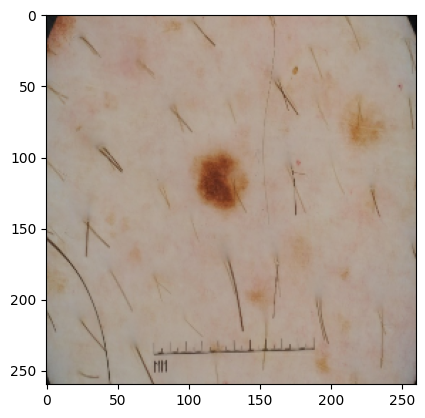

In [ ]:
def predict_with_thresholds(model, image, thresholds):

    image = load_pred(image)
    probabilities = model.predict(tf.expand_dims(image, axis=0))
    image_plot = image /255.
    plt.imshow(image_plot)
    class_labels = [
        "Basal Cell Carcinoma",
    "Melanoma",
    "Viral Skin Infections",
    "Benign Keratosis",
    "Psoriasis, Lichen Planus, and related diseases",
    "Melanocytic Nevi",
    "Seborrheic Keratoses and other Benign Tumors",
    "Fungal Skin Infections",
    "Eczema",
    "Atopic Dermatitis"
    ]


    for i, prob in enumerate(probabilities[0]):
        class_label = class_labels[i]
        if prob >= thresholds.get(class_label, 1):  # Default threshold of 1
            return class_label, prob
    print(f'Prob {probabilities}')
    return "Sorry, we don't have the data yet"


img_new = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/2. Melanoma 15.75k/ISIC_7457790.jpg'
predict_with_thresholds(my_reloaded_model, img_new, recall_scores)

In [ ]:
test_paths

array(['/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/4. Basal Cell Carcinoma (BCC) 3323/ISIC_0068402.jpg',
       '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0072834.jpg',
       '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/2. Melanoma 15.75k/ISIC_7457790.jpg',
       ...,
       '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/10. Warts Molluscum and other Viral Infections - 2103/t-warts-plantar-33.jpg',
       '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/8. Seborrheic Keratoses and other Benign Tumors - 1.8k/v-keloids-71.jpg',
       '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/2. Melanoma 15.75k/ISIC_7230898.jpg'],
      dtype=object)

In [ ]:
test_labels

array([0, 3, 1, ..., 2, 6, 1])